In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [3]:
df = pd.read_csv('../Data/single_affect_corrected.csv')

In [4]:
df

,assignment_action_id,assignment_log_id,student_user_xid,action_time,action_name,action_name-2,extended_action_name,answer_text,answer_correctness,seconds_since_last_action,teacher_xid,category_name,teacher_feedback
0,4860314,122949,41904,21:49.8,AssignmentStartedAction,AssignmentStartedAction,AssignmentStartedAction_,NaN,NaN,NaN,NaN,NaN,NaN
1,4860315,122949,41904,21:49.8,ProblemSetStartedAction,ProblemSetStartedAction,ProblemSetStartedAction_,NaN,NaN,0.010,NaN,NaN,NaN
2,4860316,122949,41904,21:50.0,ProblemSetStartedAction,ProblemSetStartedAction,ProblemSetStartedAction_,NaN,NaN,0.170,NaN,NaN,NaN
3,4860317,122949,41904,21:50.2,ProblemStartedAction,ProblemStartedAction,ProblemStartedAction_false,0 2,0.0,0.186,NaN,NaN,NaN
4,4860597,122949,41904,22:46.7,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,Figure 2,0.0,56.466,8926.0,Thoughtful self correcting,Great job sticking with it until you got the r...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151602,309446359,6818428,1164303,42:44.3,StudentSubmissionAction,StudentSubmissionAction,StudentSubmissionAction_true,58,1.0,89.018,NaN,NaN,NaN
151603,309446379,6818428,1164303,42:44.3,ProblemFinishedAction,ProblemFinishedAction,ProblemFinishedAction_true,226,1.0,0.006,NaN,NaN,NaN
151604,309446380,6818428,1164303,42:44.4,ProblemSetFinishedAction,ProblemSetFinishedAction,ProblemSetFinishedAction_,NaN,NaN,0.079,NaN,NaN,NaN
151605,309446381,6818428,1164303,42:44.4,ProblemSetFinishedAction,ProblemSetFinishedAction,ProblemSetFinishedAction_,NaN,NaN,0.040,NaN,NaN,NaN


# Preprocess to set all answer texts to None when not StudentResponseAction

In [5]:
df.answer_text.value_counts(dropna=False)

NaN             66596
3                1837
4                1683
2                1548
No               1495
                ...  
-1-1x               1
18x^14              1
2.5^2               1
(1/3)x+(1/3)        1
1015                1
Name: answer_text, Length: 15347, dtype: int64

In [6]:
df.loc[df.action_name != "StudentResponseAction", "answer_text"] = None

In [7]:
df.answer_text.value_counts(dropna=False)

NaN                  126560
No                      704
3                       516
Yes                     506
4                       463
                      ...  
C , E , H                 1
0.83                      1
7,000                     1
375                       1
(-2,-2) and (4,2)         1
Name: answer_text, Length: 2887, dtype: int64

There are 59964 instances of answer_text that have now been made NaN

# Preprocess to create label: 1 if Thoughtful self correcting, 0 if other label, NaN if not graded

In [8]:
df.category_name.value_counts(dropna=False)

NaN                                                                                            143458
Struggled and requested answer                                                                   1257
Thoughtful self correcting                                                                       1177
Thoughtful Correct Response                                                                      1039
Guessing after first attempt and gave up                                                          742
Gave up after first attempt                                                                       597
Gave up after two attempts                                                                        527
Guessing after first attempt                                                                      447
Fast self correcting                                                                              442
No attempt                                                                        

In [9]:
(df.category_name == 'Thoughtful self correcting').astype(int).value_counts(dropna=False)

0    150430
1      1177
Name: category_name, dtype: int64

In [10]:
df['label'] = (df.category_name == 'Thoughtful self correcting').astype(int)

In [11]:
# df.teacher_xid.isna().value_counts(dropna=False)

In [12]:
# df.loc[df.teacher_xid.isna(), "label"] = None

In [13]:
# df.label.value_counts(dropna=False)

# Process 'seconds_since_last_action'

In [14]:
df.seconds_since_last_action.isna().value_counts() # Check if any are na to fill with 0

False    148498
True       3109
Name: seconds_since_last_action, dtype: int64

<AxesSubplot:xlabel='action_name', ylabel='seconds_since_last_action'>

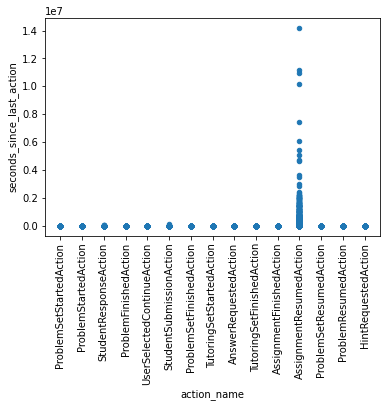

In [15]:
df[['action_name', 'seconds_since_last_action']].plot.scatter(x='action_name', y='seconds_since_last_action', rot=90)

In [16]:
df.loc[df.action_name == "AssignmentResumedAction", "seconds_since_last_action"] = 0

<AxesSubplot:xlabel='action_name', ylabel='seconds_since_last_action'>

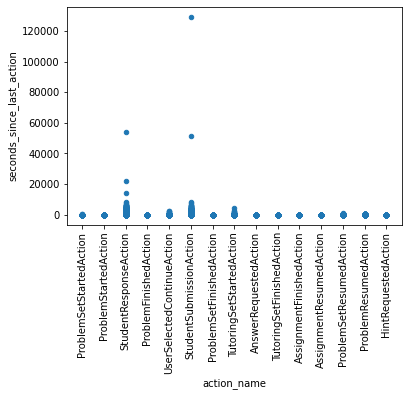

In [17]:
df[['action_name', 'seconds_since_last_action']].plot.scatter(x='action_name', y='seconds_since_last_action', rot=90)

# Subset dataset to get features

In [18]:
data_subset = df[['seconds_since_last_action', 'label']]

In [19]:
data_subset

,seconds_since_last_action,label
0,NaN,0
1,0.010,0
2,0.170,0
3,0.186,0
4,56.466,1
...,...,...
151602,89.018,0
151603,0.006,0
151604,0.079,0
151605,0.040,0


In [20]:
pd.get_dummies(df.extended_action_name)

,AnswerRequestedAction_,AssignmentFinishedAction_,AssignmentResumedAction_,AssignmentStartedAction_,HintRequestedAction_false,HintRequestedAction_true,ProblemFinishedAction_,ProblemFinishedAction_false,ProblemFinishedAction_true,ProblemResumedAction_,...,ProblemStartedAction_,ProblemStartedAction_false,ProblemStartedAction_true,StudentResponseAction_false,StudentResponseAction_true,StudentSubmissionAction_false,StudentSubmissionAction_true,TutoringSetFinishedAction_,TutoringSetStartedAction_,UserSelectedContinueAction_
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
151603,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
151604,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
pd.concat([pd.get_dummies(df['extended_action_name']), data_subset], axis=1)

,AnswerRequestedAction_,AssignmentFinishedAction_,AssignmentResumedAction_,AssignmentStartedAction_,HintRequestedAction_false,HintRequestedAction_true,ProblemFinishedAction_,ProblemFinishedAction_false,ProblemFinishedAction_true,ProblemResumedAction_,...,ProblemStartedAction_true,StudentResponseAction_false,StudentResponseAction_true,StudentSubmissionAction_false,StudentSubmissionAction_true,TutoringSetFinishedAction_,TutoringSetStartedAction_,UserSelectedContinueAction_,seconds_since_last_action,label
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.010,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.170,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.186,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,56.466,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,89.018,0
151603,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.006,0
151604,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.079,0
151605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.040,0


input shape has 24 columns (exclude label)

# Stratify dataset by student id

In [22]:
unique_students = df.student_user_xid.unique()
np.random.shuffle(unique_students)

In [23]:
students_tenfold = np.array_split(unique_students, 10)

In [24]:
def holdout_split(holdout, df):
    test = df[df.student_user_xid.isin(students_tenfold[holdout])]
    
    train = students_tenfold[:holdout] + students_tenfold[holdout+1:]
    train = [val for sublist in train for val in sublist]
    train = df[df.student_user_xid.isin(train)]
    
    return (test, train)

# grouping timeseries by assignment_log_id

In [25]:
input_cols = 24
def create_xy(df):
    groupeddf = df.groupby('assignment_log_id').agg(lambda x: x.tolist())
    del groupeddf['student_user_xid']
    
    X = groupeddf.iloc[:,:-1].to_numpy()
    y = groupeddf.iloc[:, -1:].to_numpy()
    
    XT = [np.array([np.array(xii) for xii in xi]).reshape((input_cols,-1)).T for xi in X]
    yt = [np.array([np.array(yii) for yii in yi]).reshape((1,-1)).T for yi in y]
    
    return (XT, yt)

# Create and run lstm

In [26]:
n_units = 50
n_epochs = 200
batch_size = 64
val_split = 0.2

Epoch 1/200
37/37 [==============================] - 8s 147ms/step - loss: 0.5228 - val_loss: 0.0207

Epoch 00001: val_loss improved from inf to 0.02067, saving model to best_model.h5
Epoch 2/200
37/37 [==============================] - 4s 111ms/step - loss: 0.0176 - val_loss: 0.0126

Epoch 00002: val_loss improved from 0.02067 to 0.01260, saving model to best_model.h5
Epoch 3/200
37/37 [==============================] - 4s 110ms/step - loss: 0.0125 - val_loss: 0.0108

Epoch 00003: val_loss improved from 0.01260 to 0.01082, saving model to best_model.h5
Epoch 4/200
37/37 [==============================] - 4s 113ms/step - loss: 0.0109 - val_loss: 0.0098

Epoch 00004: val_loss improved from 0.01082 to 0.00976, saving model to best_model.h5
Epoch 5/200
37/37 [==============================] - 4s 111ms/step - loss: 0.0100 - val_loss: 0.0094

Epoch 00005: val_loss improved from 0.00976 to 0.00935, saving model to best_model.h5
Epoch 6/200
37/37 [==============================] - 5s 123ms/st

37/37 [==============================] - 7s 186ms/step - loss: 0.0047 - val_loss: 0.0047

Epoch 00047: val_loss did not improve from 0.00467
Epoch 48/200
37/37 [==============================] - 5s 133ms/step - loss: 0.0047 - val_loss: 0.0045

Epoch 00048: val_loss improved from 0.00467 to 0.00449, saving model to best_model.h5
Epoch 49/200
37/37 [==============================] - 6s 153ms/step - loss: 0.0044 - val_loss: 0.0042

Epoch 00049: val_loss improved from 0.00449 to 0.00425, saving model to best_model.h5
Epoch 50/200
37/37 [==============================] - 6s 175ms/step - loss: 0.0042 - val_loss: 0.0043

Epoch 00050: val_loss did not improve from 0.00425
Epoch 51/200
37/37 [==============================] - 6s 175ms/step - loss: 0.0045 - val_loss: 0.0045

Epoch 00051: val_loss did not improve from 0.00425
Epoch 52/200
37/37 [==============================] - 5s 142ms/step - loss: 0.0046 - val_loss: 0.0043

Epoch 00052: val_loss did not improve from 0.00425
Epoch 53/200
37/37 

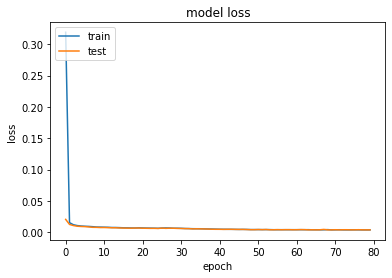

Epoch 1/200
35/35 [==============================] - 9s 162ms/step - loss: 0.5058 - val_loss: 0.0218

Epoch 00001: val_loss improved from inf to 0.02184, saving model to best_model.h5
Epoch 2/200
35/35 [==============================] - 4s 127ms/step - loss: 0.0200 - val_loss: 0.0174

Epoch 00002: val_loss improved from 0.02184 to 0.01740, saving model to best_model.h5
Epoch 3/200
35/35 [==============================] - 5s 139ms/step - loss: 0.0167 - val_loss: 0.0156

Epoch 00003: val_loss improved from 0.01740 to 0.01556, saving model to best_model.h5
Epoch 4/200
35/35 [==============================] - 5s 142ms/step - loss: 0.0156 - val_loss: 0.0135

Epoch 00004: val_loss improved from 0.01556 to 0.01351, saving model to best_model.h5
Epoch 5/200
35/35 [==============================] - 4s 123ms/step - loss: 0.0132 - val_loss: 0.0125

Epoch 00005: val_loss improved from 0.01351 to 0.01255, saving model to best_model.h5
Epoch 6/200
35/35 [==============================] - 5s 142ms/st

35/35 [==============================] - 5s 137ms/step - loss: 0.0052 - val_loss: 0.0053

Epoch 00048: val_loss did not improve from 0.00522
Epoch 49/200
35/35 [==============================] - 5s 139ms/step - loss: 0.0052 - val_loss: 0.0056

Epoch 00049: val_loss did not improve from 0.00522
Epoch 50/200
35/35 [==============================] - 4s 118ms/step - loss: 0.0049 - val_loss: 0.0051

Epoch 00050: val_loss improved from 0.00522 to 0.00512, saving model to best_model.h5
Epoch 51/200
35/35 [==============================] - 4s 116ms/step - loss: 0.0049 - val_loss: 0.0061

Epoch 00051: val_loss did not improve from 0.00512
Epoch 52/200
35/35 [==============================] - 4s 122ms/step - loss: 0.0056 - val_loss: 0.0055

Epoch 00052: val_loss did not improve from 0.00512
Epoch 53/200
35/35 [==============================] - 4s 125ms/step - loss: 0.0053 - val_loss: 0.0051

Epoch 00053: val_loss improved from 0.00512 to 0.00508, saving model to best_model.h5
Epoch 54/200
35/35 

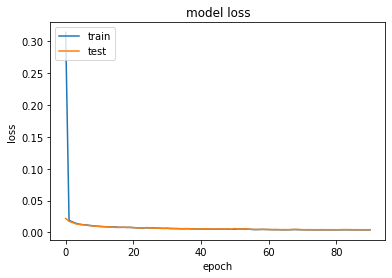

Epoch 1/200
36/36 [==============================] - 7s 118ms/step - loss: 0.5451 - val_loss: 0.0258

Epoch 00001: val_loss improved from inf to 0.02576, saving model to best_model.h5
Epoch 2/200
36/36 [==============================] - 4s 102ms/step - loss: 0.0197 - val_loss: 0.0121

Epoch 00002: val_loss improved from 0.02576 to 0.01212, saving model to best_model.h5
Epoch 3/200
36/36 [==============================] - 4s 105ms/step - loss: 0.0120 - val_loss: 0.0107

Epoch 00003: val_loss improved from 0.01212 to 0.01072, saving model to best_model.h5
Epoch 4/200
36/36 [==============================] - 4s 112ms/step - loss: 0.0107 - val_loss: 0.0097

Epoch 00004: val_loss improved from 0.01072 to 0.00970, saving model to best_model.h5
Epoch 5/200
36/36 [==============================] - 4s 110ms/step - loss: 0.0103 - val_loss: 0.0092

Epoch 00005: val_loss improved from 0.00970 to 0.00919, saving model to best_model.h5
Epoch 6/200
36/36 [==============================] - 4s 110ms/st

36/36 [==============================] - 4s 112ms/step - loss: 0.0051 - val_loss: 0.0052

Epoch 00046: val_loss improved from 0.00528 to 0.00524, saving model to best_model.h5
Epoch 47/200
36/36 [==============================] - 4s 109ms/step - loss: 0.0054 - val_loss: 0.0053

Epoch 00047: val_loss did not improve from 0.00524
Epoch 48/200
36/36 [==============================] - 4s 105ms/step - loss: 0.0053 - val_loss: 0.0050

Epoch 00048: val_loss improved from 0.00524 to 0.00496, saving model to best_model.h5
Epoch 49/200
36/36 [==============================] - 4s 104ms/step - loss: 0.0048 - val_loss: 0.0050

Epoch 00049: val_loss did not improve from 0.00496
Epoch 50/200
36/36 [==============================] - 4s 111ms/step - loss: 0.0047 - val_loss: 0.0051

Epoch 00050: val_loss did not improve from 0.00496
Epoch 51/200
36/36 [==============================] - 4s 106ms/step - loss: 0.0047 - val_loss: 0.0051

Epoch 00051: val_loss did not improve from 0.00496
Epoch 52/200
36/36 

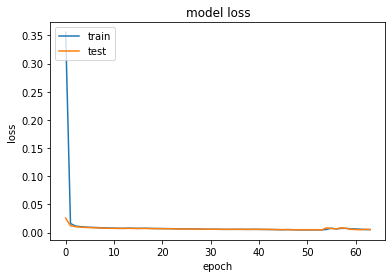

Epoch 1/200
34/34 [==============================] - 7s 130ms/step - loss: 0.5891 - val_loss: 0.0290

Epoch 00001: val_loss improved from inf to 0.02902, saving model to best_model.h5
Epoch 2/200
34/34 [==============================] - 4s 118ms/step - loss: 0.0202 - val_loss: 0.0130

Epoch 00002: val_loss improved from 0.02902 to 0.01298, saving model to best_model.h5
Epoch 3/200
34/34 [==============================] - 4s 115ms/step - loss: 0.0122 - val_loss: 0.0115

Epoch 00003: val_loss improved from 0.01298 to 0.01155, saving model to best_model.h5
Epoch 4/200
34/34 [==============================] - 4s 113ms/step - loss: 0.0116 - val_loss: 0.0106

Epoch 00004: val_loss improved from 0.01155 to 0.01065, saving model to best_model.h5
Epoch 5/200
34/34 [==============================] - 4s 113ms/step - loss: 0.0103 - val_loss: 0.0100

Epoch 00005: val_loss improved from 0.01065 to 0.00996, saving model to best_model.h5
Epoch 6/200
34/34 [==============================] - 4s 123ms/st

34/34 [==============================] - 4s 112ms/step - loss: 0.0046 - val_loss: 0.0050

Epoch 00046: val_loss improved from 0.00522 to 0.00502, saving model to best_model.h5
Epoch 47/200
34/34 [==============================] - 4s 116ms/step - loss: 0.0045 - val_loss: 0.0051

Epoch 00047: val_loss did not improve from 0.00502
Epoch 48/200
34/34 [==============================] - 4s 111ms/step - loss: 0.0045 - val_loss: 0.0051

Epoch 00048: val_loss did not improve from 0.00502
Epoch 49/200
34/34 [==============================] - 4s 112ms/step - loss: 0.0048 - val_loss: 0.0050

Epoch 00049: val_loss did not improve from 0.00502
Epoch 50/200
34/34 [==============================] - 4s 110ms/step - loss: 0.0045 - val_loss: 0.0050

Epoch 00050: val_loss improved from 0.00502 to 0.00501, saving model to best_model.h5
Epoch 51/200
34/34 [==============================] - 4s 110ms/step - loss: 0.0046 - val_loss: 0.0049

Epoch 00051: val_loss improved from 0.00501 to 0.00486, saving model t

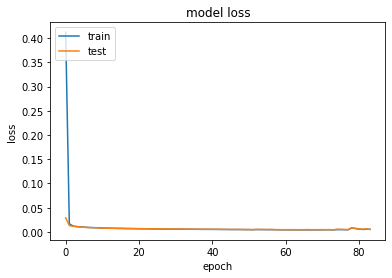

Epoch 1/200
35/35 [==============================] - 9s 159ms/step - loss: 0.5365 - val_loss: 0.0369

Epoch 00001: val_loss improved from inf to 0.03687, saving model to best_model.h5
Epoch 2/200
35/35 [==============================] - 5s 141ms/step - loss: 0.0339 - val_loss: 0.0281

Epoch 00002: val_loss improved from 0.03687 to 0.02813, saving model to best_model.h5
Epoch 3/200
35/35 [==============================] - 5s 130ms/step - loss: 0.0263 - val_loss: 0.0222

Epoch 00003: val_loss improved from 0.02813 to 0.02222, saving model to best_model.h5
Epoch 4/200
35/35 [==============================] - 5s 134ms/step - loss: 0.0216 - val_loss: 0.0196

Epoch 00004: val_loss improved from 0.02222 to 0.01964, saving model to best_model.h5
Epoch 5/200
35/35 [==============================] - 5s 130ms/step - loss: 0.0193 - val_loss: 0.0176

Epoch 00005: val_loss improved from 0.01964 to 0.01757, saving model to best_model.h5
Epoch 6/200
35/35 [==============================] - 5s 145ms/st

35/35 [==============================] - 4s 120ms/step - loss: 0.0061 - val_loss: 0.0062

Epoch 00047: val_loss improved from 0.00640 to 0.00619, saving model to best_model.h5
Epoch 48/200
35/35 [==============================] - 4s 123ms/step - loss: 0.0063 - val_loss: 0.0061

Epoch 00048: val_loss improved from 0.00619 to 0.00611, saving model to best_model.h5
Epoch 49/200
35/35 [==============================] - 4s 123ms/step - loss: 0.0060 - val_loss: 0.0059

Epoch 00049: val_loss improved from 0.00611 to 0.00591, saving model to best_model.h5
Epoch 50/200
35/35 [==============================] - 4s 125ms/step - loss: 0.0060 - val_loss: 0.0056

Epoch 00050: val_loss improved from 0.00591 to 0.00565, saving model to best_model.h5
Epoch 51/200
35/35 [==============================] - 4s 121ms/step - loss: 0.0058 - val_loss: 0.0056

Epoch 00051: val_loss improved from 0.00565 to 0.00561, saving model to best_model.h5
Epoch 52/200
35/35 [==============================] - 4s 123ms/step 

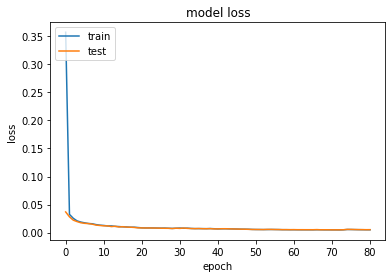

Epoch 1/200
36/36 [==============================] - 8s 150ms/step - loss: 0.5599 - val_loss: 0.0387

Epoch 00001: val_loss improved from inf to 0.03869, saving model to best_model.h5
Epoch 2/200
36/36 [==============================] - 4s 121ms/step - loss: 0.0278 - val_loss: 0.0167

Epoch 00002: val_loss improved from 0.03869 to 0.01672, saving model to best_model.h5
Epoch 3/200
36/36 [==============================] - 4s 114ms/step - loss: 0.0161 - val_loss: 0.0138

Epoch 00003: val_loss improved from 0.01672 to 0.01377, saving model to best_model.h5
Epoch 4/200
36/36 [==============================] - 4s 116ms/step - loss: 0.0135 - val_loss: 0.0128

Epoch 00004: val_loss improved from 0.01377 to 0.01281, saving model to best_model.h5
Epoch 5/200
36/36 [==============================] - 4s 118ms/step - loss: 0.0129 - val_loss: 0.0115

Epoch 00005: val_loss improved from 0.01281 to 0.01146, saving model to best_model.h5
Epoch 6/200
36/36 [==============================] - 4s 119ms/st

36/36 [==============================] - 4s 123ms/step - loss: 0.0052 - val_loss: 0.0052

Epoch 00047: val_loss improved from 0.00520 to 0.00519, saving model to best_model.h5
Epoch 48/200
36/36 [==============================] - 5s 136ms/step - loss: 0.0049 - val_loss: 0.0051

Epoch 00048: val_loss improved from 0.00519 to 0.00512, saving model to best_model.h5
Epoch 49/200
36/36 [==============================] - 4s 110ms/step - loss: 0.0050 - val_loss: 0.0051

Epoch 00049: val_loss improved from 0.00512 to 0.00506, saving model to best_model.h5
Epoch 50/200
36/36 [==============================] - 4s 107ms/step - loss: 0.0048 - val_loss: 0.0049

Epoch 00050: val_loss improved from 0.00506 to 0.00486, saving model to best_model.h5
Epoch 51/200
36/36 [==============================] - 4s 103ms/step - loss: 0.0049 - val_loss: 0.0047

Epoch 00051: val_loss improved from 0.00486 to 0.00474, saving model to best_model.h5
Epoch 52/200
36/36 [==============================] - 4s 119ms/step 

36/36 [==============================] - 3s 86ms/step - loss: 0.0036 - val_loss: 0.0041

Epoch 00097: val_loss did not improve from 0.00403
Epoch 98/200
36/36 [==============================] - 4s 103ms/step - loss: 0.0037 - val_loss: 0.0040

Epoch 00098: val_loss improved from 0.00403 to 0.00401, saving model to best_model.h5
Epoch 99/200
36/36 [==============================] - 3s 87ms/step - loss: 0.0036 - val_loss: 0.0042

Epoch 00099: val_loss did not improve from 0.00401
Epoch 100/200
36/36 [==============================] - 3s 88ms/step - loss: 0.0037 - val_loss: 0.0041

Epoch 00100: val_loss did not improve from 0.00401
Epoch 101/200
36/36 [==============================] - 3s 88ms/step - loss: 0.0036 - val_loss: 0.0040

Epoch 00101: val_loss did not improve from 0.00401
Epoch 102/200
36/36 [==============================] - 3s 85ms/step - loss: 0.0036 - val_loss: 0.0039

Epoch 00102: val_loss improved from 0.00401 to 0.00393, saving model to best_model.h5
Epoch 103/200
36/36 [

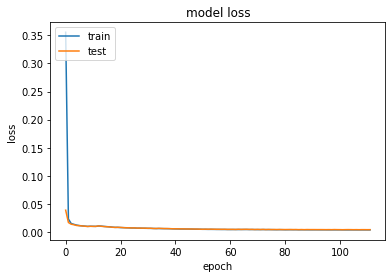

Epoch 1/200
34/34 [==============================] - 5s 93ms/step - loss: 0.5013 - val_loss: 0.0250

Epoch 00001: val_loss improved from inf to 0.02503, saving model to best_model.h5
Epoch 2/200
34/34 [==============================] - 3s 96ms/step - loss: 0.0211 - val_loss: 0.0167

Epoch 00002: val_loss improved from 0.02503 to 0.01673, saving model to best_model.h5
Epoch 3/200
34/34 [==============================] - 3s 85ms/step - loss: 0.0158 - val_loss: 0.0144

Epoch 00003: val_loss improved from 0.01673 to 0.01445, saving model to best_model.h5
Epoch 4/200
34/34 [==============================] - 3s 95ms/step - loss: 0.0139 - val_loss: 0.0133

Epoch 00004: val_loss improved from 0.01445 to 0.01325, saving model to best_model.h5
Epoch 5/200
34/34 [==============================] - 3s 91ms/step - loss: 0.0134 - val_loss: 0.0121

Epoch 00005: val_loss improved from 0.01325 to 0.01207, saving model to best_model.h5
Epoch 6/200
34/34 [==============================] - 3s 83ms/step - l

34/34 [==============================] - 12s 342ms/step - loss: 0.0058 - val_loss: 0.0057

Epoch 00046: val_loss did not improve from 0.00507
Epoch 47/200
34/34 [==============================] - 6s 178ms/step - loss: 0.0056 - val_loss: 0.0056

Epoch 00047: val_loss did not improve from 0.00507
Epoch 48/200
34/34 [==============================] - 5s 133ms/step - loss: 0.0059 - val_loss: 0.0059

Epoch 00048: val_loss did not improve from 0.00507
Epoch 49/200
34/34 [==============================] - 4s 111ms/step - loss: 0.0057 - val_loss: 0.0057

Epoch 00049: val_loss did not improve from 0.00507
Epoch 50/200
34/34 [==============================] - 4s 109ms/step - loss: 0.0057 - val_loss: 0.0052

Epoch 00050: val_loss did not improve from 0.00507
Epoch 51/200
34/34 [==============================] - 4s 108ms/step - loss: 0.0050 - val_loss: 0.0047

Epoch 00051: val_loss improved from 0.00507 to 0.00475, saving model to best_model.h5
Epoch 52/200
34/34 [==============================] -

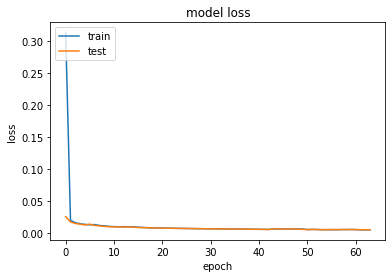

Epoch 1/200
36/36 [==============================] - 7s 128ms/step - loss: 0.5032 - val_loss: 0.0233

Epoch 00001: val_loss improved from inf to 0.02331, saving model to best_model.h5
Epoch 2/200
36/36 [==============================] - 4s 106ms/step - loss: 0.0196 - val_loss: 0.0154

Epoch 00002: val_loss improved from 0.02331 to 0.01543, saving model to best_model.h5
Epoch 3/200
36/36 [==============================] - 4s 118ms/step - loss: 0.0151 - val_loss: 0.0132

Epoch 00003: val_loss improved from 0.01543 to 0.01318, saving model to best_model.h5
Epoch 4/200
36/36 [==============================] - 4s 117ms/step - loss: 0.0127 - val_loss: 0.0116

Epoch 00004: val_loss improved from 0.01318 to 0.01162, saving model to best_model.h5
Epoch 5/200
36/36 [==============================] - 4s 118ms/step - loss: 0.0116 - val_loss: 0.0106

Epoch 00005: val_loss improved from 0.01162 to 0.01059, saving model to best_model.h5
Epoch 6/200
36/36 [==============================] - 4s 108ms/st

36/36 [==============================] - 4s 118ms/step - loss: 0.0046 - val_loss: 0.0049

Epoch 00047: val_loss improved from 0.00494 to 0.00487, saving model to best_model.h5
Epoch 48/200
36/36 [==============================] - 5s 154ms/step - loss: 0.0045 - val_loss: 0.0048

Epoch 00048: val_loss improved from 0.00487 to 0.00483, saving model to best_model.h5
Epoch 49/200
36/36 [==============================] - 4s 114ms/step - loss: 0.0048 - val_loss: 0.0047

Epoch 00049: val_loss improved from 0.00483 to 0.00472, saving model to best_model.h5
Epoch 50/200
36/36 [==============================] - 5s 150ms/step - loss: 0.0046 - val_loss: 0.0047

Epoch 00050: val_loss improved from 0.00472 to 0.00471, saving model to best_model.h5
Epoch 51/200
36/36 [==============================] - 5s 126ms/step - loss: 0.0047 - val_loss: 0.0045

Epoch 00051: val_loss improved from 0.00471 to 0.00448, saving model to best_model.h5
Epoch 52/200
36/36 [==============================] - 4s 118ms/step 

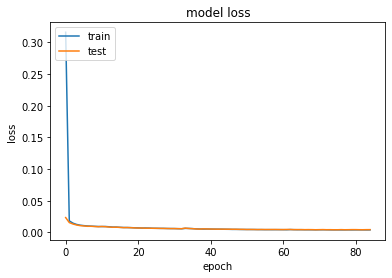

Epoch 1/200
36/36 [==============================] - 5s 99ms/step - loss: 0.5718 - val_loss: 0.0326

Epoch 00001: val_loss improved from inf to 0.03262, saving model to best_model.h5
Epoch 2/200
36/36 [==============================] - 3s 88ms/step - loss: 0.0245 - val_loss: 0.0163

Epoch 00002: val_loss improved from 0.03262 to 0.01634, saving model to best_model.h5
Epoch 3/200
36/36 [==============================] - 3s 88ms/step - loss: 0.0160 - val_loss: 0.0149

Epoch 00003: val_loss improved from 0.01634 to 0.01492, saving model to best_model.h5
Epoch 4/200
36/36 [==============================] - 3s 86ms/step - loss: 0.0144 - val_loss: 0.0133

Epoch 00004: val_loss improved from 0.01492 to 0.01332, saving model to best_model.h5
Epoch 5/200
36/36 [==============================] - 3s 86ms/step - loss: 0.0131 - val_loss: 0.0123

Epoch 00005: val_loss improved from 0.01332 to 0.01233, saving model to best_model.h5
Epoch 6/200
36/36 [==============================] - 3s 86ms/step - l

36/36 [==============================] - 3s 87ms/step - loss: 0.0050 - val_loss: 0.0053

Epoch 00048: val_loss improved from 0.00543 to 0.00527, saving model to best_model.h5
Epoch 49/200
36/36 [==============================] - 3s 89ms/step - loss: 0.0053 - val_loss: 0.0053

Epoch 00049: val_loss did not improve from 0.00527
Epoch 50/200
36/36 [==============================] - 3s 94ms/step - loss: 0.0050 - val_loss: 0.0054

Epoch 00050: val_loss did not improve from 0.00527
Epoch 51/200
36/36 [==============================] - 3s 88ms/step - loss: 0.0053 - val_loss: 0.0055

Epoch 00051: val_loss did not improve from 0.00527
Epoch 52/200
36/36 [==============================] - 3s 87ms/step - loss: 0.0050 - val_loss: 0.0053

Epoch 00052: val_loss did not improve from 0.00527
Epoch 53/200
36/36 [==============================] - 3s 86ms/step - loss: 0.0049 - val_loss: 0.0053

Epoch 00053: val_loss did not improve from 0.00527
Epoch 54/200
36/36 [==============================] - 3s 89m

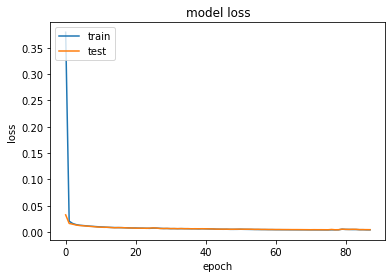

Epoch 1/200
35/35 [==============================] - 6s 118ms/step - loss: 0.5281 - val_loss: 0.0217

Epoch 00001: val_loss improved from inf to 0.02172, saving model to best_model.h5
Epoch 2/200
35/35 [==============================] - 4s 101ms/step - loss: 0.0190 - val_loss: 0.0159

Epoch 00002: val_loss improved from 0.02172 to 0.01595, saving model to best_model.h5
Epoch 3/200
35/35 [==============================] - 4s 106ms/step - loss: 0.0147 - val_loss: 0.0124

Epoch 00003: val_loss improved from 0.01595 to 0.01242, saving model to best_model.h5
Epoch 4/200
35/35 [==============================] - 3s 98ms/step - loss: 0.0120 - val_loss: 0.0112

Epoch 00004: val_loss improved from 0.01242 to 0.01120, saving model to best_model.h5
Epoch 5/200
35/35 [==============================] - 3s 100ms/step - loss: 0.0109 - val_loss: 0.0097

Epoch 00005: val_loss improved from 0.01120 to 0.00973, saving model to best_model.h5
Epoch 6/200
35/35 [==============================] - 3s 97ms/step


Epoch 00048: val_loss did not improve from 0.00467
Epoch 49/200
35/35 [==============================] - 3s 93ms/step - loss: 0.0045 - val_loss: 0.0048

Epoch 00049: val_loss did not improve from 0.00467
Epoch 50/200
35/35 [==============================] - 3s 92ms/step - loss: 0.0044 - val_loss: 0.0042

Epoch 00050: val_loss improved from 0.00467 to 0.00420, saving model to best_model.h5
Epoch 51/200
35/35 [==============================] - 3s 93ms/step - loss: 0.0043 - val_loss: 0.0046

Epoch 00051: val_loss did not improve from 0.00420
Epoch 52/200
35/35 [==============================] - 3s 92ms/step - loss: 0.0047 - val_loss: 0.0069

Epoch 00052: val_loss did not improve from 0.00420
Epoch 53/200
35/35 [==============================] - 3s 94ms/step - loss: 0.0061 - val_loss: 0.0053

Epoch 00053: val_loss did not improve from 0.00420
Epoch 54/200
35/35 [==============================] - 3s 95ms/step - loss: 0.0049 - val_loss: 0.0051

Epoch 00054: val_loss did not improve from 0.0

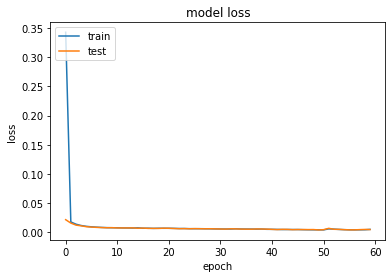

In [27]:
data_subset = df[['seconds_since_last_action', 'label']]
inputdf = pd.concat([df[['assignment_log_id', 'student_user_xid']], pd.get_dummies(df['extended_action_name']), data_subset], axis=1)

# Call model.fit 10 times and output predictions and actual values (calculate metrics later: auc, kappa, recall)
# Call model.predict passing in test
X_train_predict, X_test_predict = [], []
X_train, Y_train = [None for i in range(10)], [None for i in range(10)]
X_test, Y_test = [None for i in range(10)], [None for i in range(10)]

# inputs = keras.Input(shape=(None, input_cols), dtype="float32")

for i in range(0, 10):
    test, train = holdout_split(i, inputdf)
    X_train[i], Y_train[i] = create_xy(train)
    X_test[i], Y_test[i] = create_xy(test) 

for i in range(0, 10):
    lstm_model = keras.Sequential([
        keras.layers.LSTM(n_units, input_shape=(None, input_cols), return_sequences=True), 
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Notes: binary cross entropy loss function, optimization: adam or adagrad
    lstm_model.compile(
        loss='binary_crossentropy',
#         loss='categorical_crossentropy',
        optimizer='adam'
    )
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    
    history = lstm_model.fit(
        tf.keras.preprocessing.sequence.pad_sequences(X_train[i], padding='post'), # TODO: Does this need to get padded to 249?
        tf.keras.preprocessing.sequence.pad_sequences(Y_train[i], padding='post'),
        epochs=n_epochs,
        batch_size=batch_size,
        validation_split=val_split,
        callbacks=[es, mc]
    )

    saved_model = load_model('best_model.h5')
#     X_train_predict.append(lstm_model.predict(tf.keras.preprocessing.sequence.pad_sequences(X_train)))
    X_test_predict.append(saved_model.predict(tf.keras.preprocessing.sequence.pad_sequences(X_test[i])))
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [28]:
# Flatten and remove post padding
Y_flattened = []
for i in range(10):
#     print("Base length:", len(Y_test[i]))
    Y_test_flat = np.array([])
    for seq in Y_test[i]:
        Y_test_flat = np.append(Y_test_flat,seq.ravel())
#     Y_flattened.append(Y_test_flat.reshape((-1,1)))
    Y_flattened.append(Y_test_flat)

#     print("Flattened length:", len(Y_test_flat.reshape((-1,1))))
#     print("First sequence:", len(Y_test_flat.reshape((-1,1))) / len(Y_test[i]))
#     print("First length:", len(Y_test[i][0]))
#     print()

In [29]:
for i in range(10):
#     print("Base length:", len(X_test_predict[i]))
    predict_test_flat = np.array([])
    for seq in X_test_predict[i]:
        predict_test_flat = np.append(predict_test_flat, seq.ravel())
    predict_test_flat.reshape((-1,1))
#     print("Flattened length:", len(predict_test_flat.reshape((-1,1))))
#     print("Per sequence:", len(predict_test_flat.reshape((-1,1))) / len(X_test_predict[i]))
#     print("First length:", len(X_test_predict[i][0]))
#     print()

In [30]:
predict_unpadded = []
for i in range(len(Y_test)):
    predict = np.array([])
    for j in range(len(Y_test[i])):
        unpadded_length = len(Y_test[i][j])
        predict = np.append(predict, X_test_predict[i][j][:unpadded_length])
    predict_unpadded.append(predict)

In [31]:
len(Y_flattened[0]), len(predict_unpadded[0])

(8547, 8547)

In [32]:
for i in range(10):
    fpr, tpr, thresholds = metrics.roc_curve(Y_flattened[i], predict_unpadded[i])
    print('Test Score Fold %d: %.2f AUC' % (i, metrics.auc(fpr, tpr)))

Test Score Fold 0: 0.63 AUC
Test Score Fold 1: 0.61 AUC
Test Score Fold 2: 0.67 AUC
Test Score Fold 3: 0.64 AUC
Test Score Fold 4: 0.71 AUC
Test Score Fold 5: 0.66 AUC
Test Score Fold 6: 0.54 AUC
Test Score Fold 7: 0.69 AUC
Test Score Fold 8: 0.66 AUC
Test Score Fold 9: 0.65 AUC


In [33]:
for i in range(10):
    kappa = metrics.cohen_kappa_score(Y_flattened[i], np.where(predict_unpadded[i] > 0.5, 1, 0))
    print('Test Score Fold %d: %f Kappa' % (i, kappa))

Test Score Fold 0: 0.000000 Kappa
Test Score Fold 1: -0.000344 Kappa
Test Score Fold 2: 0.000000 Kappa
Test Score Fold 3: -0.000175 Kappa
Test Score Fold 4: 0.000000 Kappa
Test Score Fold 5: -0.000378 Kappa
Test Score Fold 6: -0.000460 Kappa
Test Score Fold 7: 0.018943 Kappa
Test Score Fold 8: -0.000353 Kappa
Test Score Fold 9: 0.000000 Kappa


In [34]:
for i in range(10):
    testScore = metrics.mean_squared_error(Y_flattened[i], predict_unpadded[i], squared=False)
    print('Test Score Fold %d: %f RMSE' % (i, testScore))

Test Score Fold 0: 0.148674 RMSE
Test Score Fold 1: 0.160985 RMSE
Test Score Fold 2: 0.146772 RMSE
Test Score Fold 3: 0.141683 RMSE
Test Score Fold 4: 0.151697 RMSE
Test Score Fold 5: 0.164510 RMSE
Test Score Fold 6: 0.146594 RMSE
Test Score Fold 7: 0.148104 RMSE
Test Score Fold 8: 0.148914 RMSE
Test Score Fold 9: 0.154043 RMSE


In [35]:
saved_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 50)          15000     
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           51        
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras.utils import plot_model

# import pydot as pyd
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# keras.utils.vis_utils.pydot = pyd

plot_model(saved_model, to_file='single_behavior_model.png')
data = plt.imread('single_behavior_model.png')
plt.imshow(data)
plt.show()

# def visualize_model(model):
#     return SVG(model_to_dot(model).create(prog='dot', format='svg'))

# visualize_model(saved_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


FileNotFoundError: [Errno 2] No such file or directory: 'single_behavior_model.png'